# <span style="color:blue">LDA model (2019_Feb) - 10 topics</span>

In [1]:
yyyy_MMM = '2019_Feb'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
from numpy import savetxt
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = False
# if sample > 0, then we take a sample of the entire dataset (for debugging purpose)
sample = 0
# parameters to build the lda model
num_topics = 10

if test:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model'
    # chunksize to build LDA model
    chunksize = 250
else:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model'
    # chunksize to build LDA model
    chunksize = 5000

# path + name of the file that contains the documents preprocessed
file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
# path + name of the file that contains the model gotten at the end
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc\2019_Feb\2019_Feb_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model\2019_Feb\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc, index_col='id_doc')
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
2951573    ['steppin', 'season', 'hair', 'attitude', 'eee...
1822416    ['comfortable', 'express', 'boundary', 'uncomf...
2615526                         ['random', 'fabric', 'fold']
2240482    ['aiya', 'veggie', 'harder', 'expect', 'live',...
2202972                                          ['clothes']
2265680                     ['throwback', 'omega', 'choice']
2760729                                ['everyday', 'cheat']
2726391    ['island', 'hour', 'place', 'guess', 'healthy'...
2797483    ['post', 'workout', 'video', 'record', 'year',...
2360391               ['finally', 'visit', 'nova', 'scotia']
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
2433880    ['fourth', 'strong', 'cafe', 'open', 'door', '...
2604364    ['forward', 'summer', 'chicken', 'fulk', 'desi...
2663360    ['initial', 'clean', 'clear', 'design', 'leath...
3051003    ['beauty', 'cosmetic', 'green', 'dragon', 'leg...
1915431    ['panas', 'bookshop', 'fauve', 'dream', 'virgi...
2601517    ['find', 'anna', 'karin', 'karlsson', 'collect...
2216972    ['hola', 'chicas', 'hola', 'ibiza', 'good', 'v...
2033688    ['maternity', 'dress', 'peony', 'pregnant', 't...
1960555    ['anniversary', 'vogue', 'talent', 'vogue', 't...
2399549    ['diary', 'beauty', 'addict', 'food', 'food', ...
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the number of words appearing in each document  

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(103199,)


<AxesSubplot:>

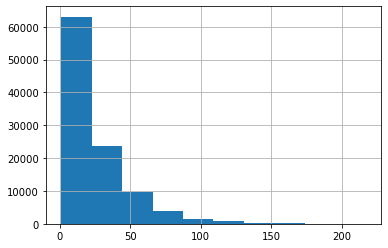

In [7]:
print(documents.shape)

documents.str.split().\
    map(lambda x: len(x)).\
    hist()

### Remove words that appear only once

In [8]:
####################### PENDING

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text

In [9]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute bigrams & trigrams  

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [10]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Categorizing and tagging words

In [11]:
# function to remove accented characters
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dictionary with the entire dataset

In [12]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus_total = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save document-term matrix

In [13]:
# save document-term matrix
savetxt(file_model + '_document_term_matrix.csv', corpus_total, delimiter=',', fmt='% s')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Build LDA model

In [14]:
perplexity_score = []
coherence_score = []
indixes = []

index = 0
chunk_size = 250
documents_sample = documents[index:chunk_size-1]

time_start = time.time()

data_words = list(sent_to_words(documents_sample))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# # Create Dictionary
# id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=50
                                       ,per_word_topics=True)

indixes.append(index)

# Evaluate LDA Model
# Compute Perplexity Score
perplexity = lda_model.log_perplexity(corpus)
perplexity_score.append(perplexity)

# Evaluate LDA Model
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence = coherence_lda_model.get_coherence()
coherence_score.append(coherence)

# Save LDA Model
temp_file = datapath(file_model)
lda_model.save(temp_file)
temp_file = datapath(file_model + '_' + str(index).zfill(5))
lda_model.save(temp_file)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:44.85


### Incremental learning

In [15]:
documents_len = len(documents)

while index+(index+1)*chunk_size < documents_len:
    
    time_start = time.time()
    
    print(index, ' ----- ', (index+1)*chunk_size, ' ----- ', ((index+1)*chunk_size)+chunk_size-1)
    documents_sample = documents[(index+1)*chunk_size:((index+1)*chunk_size)+chunk_size-1]
    
    data_words = list(sent_to_words(documents_sample))
    # Compute bigrams & trigrams
    bi_tri_grams(data_words, 250)
    # Categorizing and tagging words
    data_words = list(map(tag_words, data_words))
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Load LDA Model
    temp_file = datapath(file_model)
    lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)
    # Update LDA Model
    lda_model.update(corpus)
    
    index = index + 1
    indixes.append(index)
    
    # Evaluate LDA Model
    # Compute Perplexity Score
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_score.append(perplexity)

    # Evaluate LDA Model
    # Compute Coherence Score
    coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    
    # Save LDA Model
    temp_file = datapath(file_model)
    lda_model.save(temp_file)
    temp_file = datapath(file_model + '_' + str(index).zfill(5))
    lda_model.save(temp_file)
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

0  -----  250  -----  499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:43.17
1  -----  500  -----  749
time elapsed - 00:00:42.98
2  -----  750  -----  999
time elapsed - 00:00:42.21
3  -----  1000  -----  1249
time elapsed - 00:00:44.04
4  -----  1250  -----  1499
time elapsed - 00:00:41.10
5  -----  1500  -----  1749
time elapsed - 00:00:42.14
6  -----  1750  -----  1999
time elapsed - 00:00:44.39
7  -----  2000  -----  2249
time elapsed - 00:00:43.51
8  -----  2250  -----  2499
time elapsed - 00:00:40.85
9  -----  2500  -----  2749
time elapsed - 00:00:43.10
10  -----  2750  -----  2999
time elapsed - 00:00:42.71
11  -----  3000  -----  3249
time elapsed - 00:00:42.03
12  -----  3250  -----  3499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.88
13  -----  3500  -----  3749
time elapsed - 00:00:44.58
14  -----  3750  -----  3999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.33
15  -----  4000  -----  4249
time elapsed - 00:00:45.54
16  -----  4250  -----  4499
time elapsed - 00:00:51.61
17  -----  4500  -----  4749
time elapsed - 00:00:48.98
18  -----  4750  -----  4999
time elapsed - 00:00:47.26
19  -----  5000  -----  5249
time elapsed - 00:00:46.96
20  -----  5250  -----  5499
time elapsed - 00:00:46.55
21  -----  5500  -----  5749
time elapsed - 00:00:46.57
22  -----  5750  -----  5999
time elapsed - 00:00:50.24
23  -----  6000  -----  6249
time elapsed - 00:00:48.47
24  -----  6250  -----  6499
time elapsed - 00:00:48.02
25  -----  6500  -----  6749
time elapsed - 00:00:46.55
26  -----  6750  -----  6999
time elapsed - 00:00:45.38
27  -----  7000  -----  7249
time elapsed - 00:00:45.43
28  -----  7250  -----  7499
time elapsed - 00:00:46.33
29  -----  7500  -----  7749
time elapsed - 00:00:49.82
30  -----  7750  -----  7999
time elapsed - 00:00:50.91
31  -----  8000  -----  8249
time elapsed - 00:00:50.42
32  -----  8250  ----

time elapsed - 00:00:37.03
157  -----  39500  -----  39749
time elapsed - 00:00:35.26
158  -----  39750  -----  39999
time elapsed - 00:00:37.60
159  -----  40000  -----  40249
time elapsed - 00:00:38.92
160  -----  40250  -----  40499
time elapsed - 00:00:37.83
161  -----  40500  -----  40749
time elapsed - 00:00:36.24
162  -----  40750  -----  40999
time elapsed - 00:00:36.22
163  -----  41000  -----  41249
time elapsed - 00:00:37.52
164  -----  41250  -----  41499
time elapsed - 00:00:37.27
165  -----  41500  -----  41749
time elapsed - 00:00:37.28
166  -----  41750  -----  41999
time elapsed - 00:00:37.37
167  -----  42000  -----  42249
time elapsed - 00:00:38.34
168  -----  42250  -----  42499
time elapsed - 00:00:38.52
169  -----  42500  -----  42749
time elapsed - 00:00:37.65
170  -----  42750  -----  42999
time elapsed - 00:00:36.60
171  -----  43000  -----  43249
time elapsed - 00:00:36.43
172  -----  43250  -----  43499
time elapsed - 00:00:36.39
173  -----  43500  -----  437

time elapsed - 00:00:33.48
296  -----  74250  -----  74499
time elapsed - 00:00:29.65
297  -----  74500  -----  74749
time elapsed - 00:00:31.26
298  -----  74750  -----  74999
time elapsed - 00:00:30.59
299  -----  75000  -----  75249
time elapsed - 00:00:31.14
300  -----  75250  -----  75499
time elapsed - 00:00:32.68
301  -----  75500  -----  75749
time elapsed - 00:00:32.72
302  -----  75750  -----  75999
time elapsed - 00:00:31.75
303  -----  76000  -----  76249
time elapsed - 00:00:31.91
304  -----  76250  -----  76499
time elapsed - 00:00:31.38
305  -----  76500  -----  76749
time elapsed - 00:00:31.96
306  -----  76750  -----  76999
time elapsed - 00:00:31.66
307  -----  77000  -----  77249
time elapsed - 00:00:30.81
308  -----  77250  -----  77499
time elapsed - 00:00:31.35
309  -----  77500  -----  77749
time elapsed - 00:00:31.72
310  -----  77750  -----  77999
time elapsed - 00:00:31.44
311  -----  78000  -----  78249
time elapsed - 00:00:29.68
312  -----  78250  -----  784

### Topics in LDA model

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"parent" + 0.027*"school" + 0.023*"care" + 0.023*"gift" + '
  '0.020*"coffee" + 0.020*"kid" + 0.020*"project" + 0.020*"motherhood" + '
  '0.020*"cloth" + 0.017*"cat"'),
 (1,
  '0.048*"house" + 0.048*"store" + 0.030*"tomorrow" + 0.030*"stone" + '
  '0.026*"honey" + 0.024*"party" + 0.024*"bridal" + 0.018*"matalan" + '
  '0.018*"decor" + 0.018*"lamborghini"'),
 (2,
  '0.041*"style" + 0.040*"fashion" + 0.033*"life" + 0.027*"summer" + '
  '0.025*"blogger" + 0.023*"love" + 0.022*"time" + 0.019*"year" + '
  '0.018*"today" + 0.018*"hair"'),
 (3,
  '0.062*"beauty" + 0.028*"outfit" + 0.025*"color" + 0.023*"doll" + '
  '0.020*"palette" + 0.020*"place" + 0.017*"face" + 0.017*"artist" + '
  '0.017*"makeup" + 0.017*"brow"'),
 (4,
  '0.055*"baby" + 0.026*"model" + 0.023*"sale" + 0.022*"deal" + '
  '0.019*"collection" + 0.019*"shirt" + 0.017*"wine" + 0.017*"vintage" + '
  '0.017*"ticket" + 0.015*"disney"'),
 (5,
  '0.053*"woman" + 0.027*"birthday" + 0.021*"power" + 0.018*"necklace" + '
 

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot perplexity score progress along incremental learning iterations  

Lower the perplexity score represents a better model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


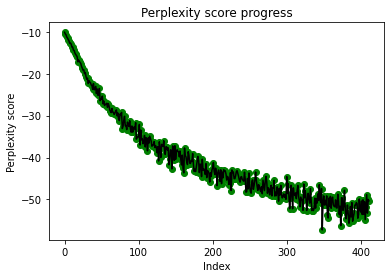

In [17]:
plt.title('Perplexity score progress')
plt.xlabel('Index')
plt.ylabel('Perplexity score')
plt.plot(indixes, perplexity_score, 'go', perplexity_score, 'k')
plt.show()

### Plot coherence score progress along incremental learning iterations  

Higher the coherence score represents a more human interpretable model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


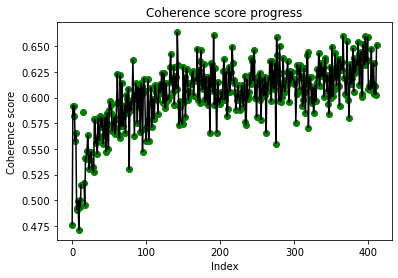

In [18]:
plt.title('Coherence score progress')
plt.xlabel('Index')
plt.ylabel('Coherence score')
plt.plot(indixes, coherence_score, 'go', coherence_score, 'k') 
plt.show()

### Visualize the topics-keywords

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.429604 -0.118961       1        1  32.281581
3     -0.084612  0.419435       2        1  13.618541
4     -0.039938 -0.082768       3        1  10.560173
5      0.071764 -0.142052       4        1   7.732813
9      0.070806  0.012504       5        1   6.845002
0      0.078006 -0.060211       6        1   6.802926
8      0.096268 -0.039728       7        1   6.685676
6      0.059488  0.043103       8        1   6.177601
7      0.098556 -0.060836       9        1   5.469041
1      0.079266  0.029513      10        1   3.826646, topic_info=         Term       Freq      Total Category  logprob  loglift
64     beauty  36.000000  36.000000  Default  30.0000  30.0000
200     style  57.000000  57.000000  Default  29.0000  29.0000
125   fashion  56.000000  56.000000  Default  28.0000  28.0000
619      baby  25.000000  25.000000  Default  27.0000  27.0000
88       life  45.000000  45.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
1265     beat   1.007707   1.009854  Topic10  -5.1059   3.2611
2019    honey   4.398892   5.024997  Topic10  -3.6322   3.1301
5841     cake   2.144090   3.004779  Topic10  -4.3509   2.9257
1240    james   2.113816   3.004122  Topic10  -4.3651   2.9117
608    return   1.287283   1.976746  Topic10  -4.8611   2.8343

[366 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
55514      5  1.008239  agoraphobia
2224       9  1.012848        album
8099       5  1.008741      anxiety
5562       3  1.021432        arket
887        2  1.014665       artist
...      ...       ...          ...
174        4  1.004336        woman
168        1  0.984090         work
913        9  1.012722      workout
632        4  1.004080       writer
175        1  1.012499         year

[355 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 6, 10, 1, 9, 7, 8, 2])

### Save document-topic matrix (most significant topic per document)  
 https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
 https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [20]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

doc_num, topic_num, prob = [], [], []

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
    
data = {'Document': doc_num
        ,'Topic': topic_num
        ,'Probability': prob}
df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document  Topic  Probability
0        2433880      2     0.190662
1        2604364      2     0.775031
2        2663360      2     0.358793
3        3051003      3     0.463783
4        1915431      7     0.367031
...          ...    ...          ...
103194   3081468      3     0.496684
103195   2395202      5     0.275091
103196   2577561      1     0.100000
103197   2492105      6     0.100098
103198   1642674      2     0.569832

[103199 rows x 3 columns]


### Save document-topic matrix (all topic's probability per document)  
https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [21]:
doc_num = []
prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9 = ([] for i in range(num_topics))

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    prob0.append(get_document_topics[0][1])
    prob1.append(get_document_topics[1][1])
    prob2.append(get_document_topics[2][1])
    prob3.append(get_document_topics[3][1])
    prob4.append(get_document_topics[4][1])
    prob5.append(get_document_topics[5][1])
    prob6.append(get_document_topics[6][1])
    prob7.append(get_document_topics[7][1])
    prob8.append(get_document_topics[8][1])
    prob9.append(get_document_topics[9][1])
    
data = {'Document': doc_num
        ,'Topic0': prob0
        ,'Topic1': prob1
        ,'Topic2': prob2
        ,'Topic3': prob3
        ,'Topic4': prob4
        ,'Topic5': prob5
        ,'Topic6': prob6
        ,'Topic7': prob7
        ,'Topic8': prob8
        ,'Topic9': prob9}

df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix_full.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5  \
0        2433880  0.063766  0.128194  0.190661  0.063684  0.129979  0.063751   
1        2604364  0.024997  0.024997  0.775031  0.024997  0.024997  0.024997   
2        2663360  0.300061  0.005882  0.358793  0.005882  0.064630  0.005882   
3        3051003  0.002197  0.024525  0.223470  0.463781  0.068137  0.024121   
4        1915431  0.033310  0.033310  0.366484  0.033310  0.033310  0.033312   
...          ...       ...       ...       ...       ...       ...       ...   
103194   3081468  0.002599  0.002599  0.352210  0.496684  0.002599  0.028546   
103195   2395202  0.024994  0.024994  0.274921  0.024994  0.275032  0.275091   
103196   2577561  0.100000  0.100000  0.100000  0.100000  0.100000  0.100000   
103197   2492105  0.100002  0.099986  0.099985  0.099986  0.099986  0.100000   
103198   1642674  0.003332  0.003332  0.569832  0.169979  0.003334  0.003332   

          Topic6    Topic7    Topic8   

### Save topic-term matrix

In [22]:
# get topic-term-matrix
topic_term_matrix = lda_model.get_topics()
# save topic-term matrix
savetxt(file_model + '_topic_term_matrix.csv', topic_term_matrix, delimiter=',')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
